### A Park for every neighbourhood in Toronto
by _Marc Behrens_

In [1]:
# import libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [2]:
# Import the dataframe of Postalcodes, Boroughs and neighbourhoods of Toronto created in the notebook submitted before.
# The Toronto neighbourhoods with its coordinates is a dataframe we already have created in earlier exercises. They were created on basis of:
# + the Wikipedia-Page 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
# + a csv-file with the coordinates of the postal codes in Toronto: https://cocl.us/Geospatial_data
df_toronto = pd.read_csv("toronto-neighbourhoods-coord.csv")

In [3]:
df_toronto.head()

Unnamed: 0 Postal Code           Borough  \
0           0         M3A        North York   
1           1         M4A        North York   
2           2         M5A  Downtown Toronto   
3           3         M6A        North York   
4           4         M7A  Downtown Toronto   

                                 Neighbourhood   Latitude  Longitude  
0                                    Parkwoods  43.753259 -79.329656  
1                             Victoria Village  43.725882 -79.315572  
2                    Regent Park, Harbourfront  43.654260 -79.360636  
3             Lawrence Manor, Lawrence Heights  43.718518 -79.464763  
4  Queen's Park, Ontario Provincial Government  43.662301 -79.389494

In [4]:
# map of Toronto with the neighborhoods.
map_toronto = folium.Map(location=[43.679563, -79.377529], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

As the rendering of Folium_maps in github does not work, I insert the image here:
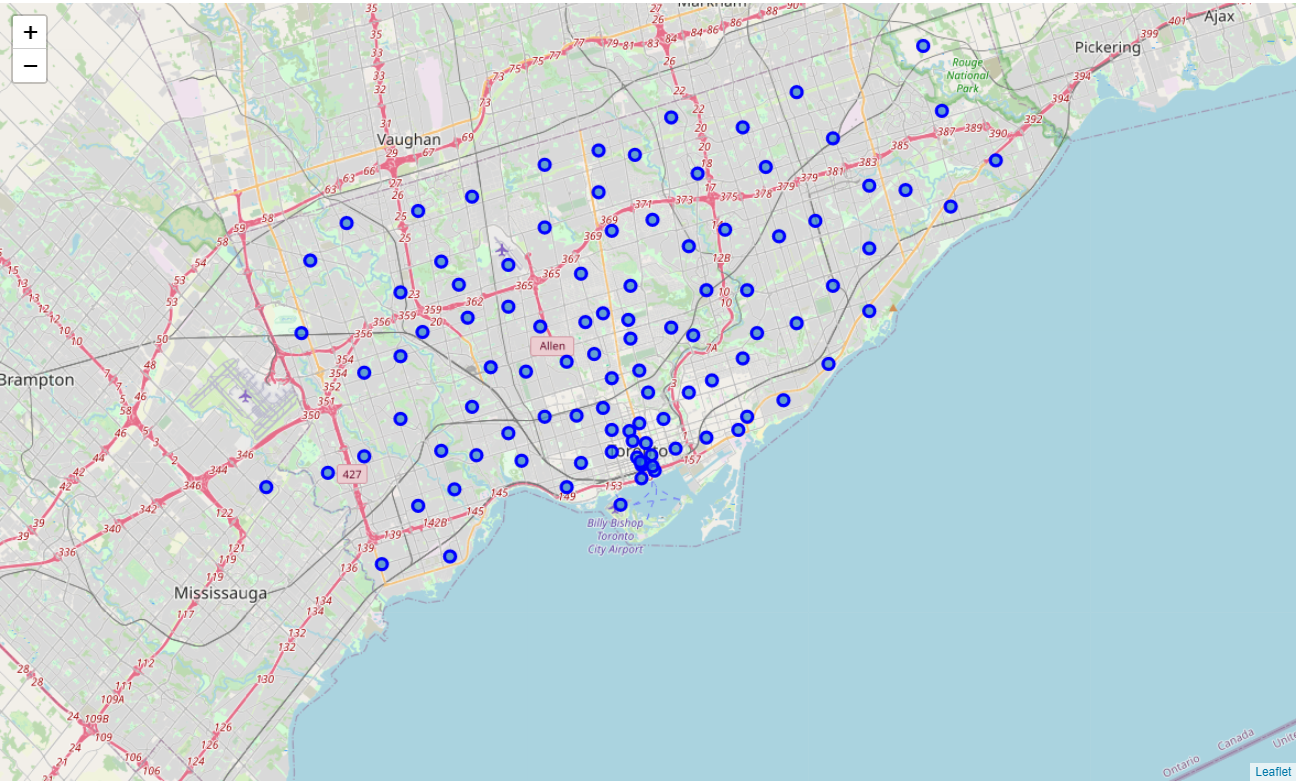

In [5]:
# Foursquare credentials
CLIENT_ID = '1EX5D3DJHD5WVXUQ5JOFATMJ3S5BNRYBETZVAG1RDPH00YLC' # your Foursquare ID
CLIENT_SECRET = 'UNR20VCVBPYVVLQVCKJM443FK1LP4FIVWLJNYU4TTW3QFLUV' # your Foursquare Secret
VERSION = '20201108'#'20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1EX5D3DJHD5WVXUQ5JOFATMJ3S5BNRYBETZVAG1RDPH00YLC
CLIENT_SECRET:UNR20VCVBPYVVLQVCKJM443FK1LP4FIVWLJNYU4TTW3QFLUV


In [6]:
# Funtion to get the nearby parks of the neighbourhoods
def getNearbyParks(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        #results = requests.get(url).json()["response"]['groups'][0]['items']
        
        response = requests.get(url).json()["response"]
        
        if "groups" in response and "items" in response['groups'][0] :
            for item in response['groups'][0]['items'] :
                if item['venue']['categories'][0]['name'] == 'Park' :
                    venues_list.append((
                        name, 
                        lat, 
                        lng, 
                        item['venue']['name'], 
                        item['venue']['location']['lat'], 
                        item['venue']['location']['lng'],  
                        item['venue']['categories'][0]['name']))

    nearby_parks = pd.DataFrame(venues_list, columns=['Neighborhood', 
                                                        'Neighborhood Latitude', 
                                                        'Neighborhood Longitude', 
                                                        'Venue', 
                                                        'Venue Latitude', 
                                                        'Venue Longitude', 
                                                        'Venue Category'])
    
    
    return(nearby_parks)

In [7]:
toronto_parks = getNearbyParks(names=df_toronto['Neighbourhood'], latitudes=df_toronto['Latitude'], longitudes=df_toronto['Longitude'])
toronto_parks.shape

(57, 7)

In [8]:
# Count Parks by neighborhood
toronto_only_parks=toronto_parks[['Neighborhood', 'Venue Category']].groupby(['Neighborhood']).count()
toronto_only_parks

Venue Category
Neighborhood                                                      
Bathurst Manor, Wilson Heights, Downsview North                  1
Berczy Park                                                      1
Business reply mail Processing Centre, South Ce...               1
Caledonia-Fairbanks                                              2
Central Bay Street                                               1
Christie                                                         2
Church and Wellesley                                             1
Commerce Court, Victoria Hotel                                   1
Davisville                                                       1
Davisville North                                                 1
Downsview                                                        2
Dufferin, Dovercourt Village                                     1
East Toronto, Broadview North (Old East York)                    1
Forest Hill North & West, Forest Hill Road Park                  1
Garden District, Ryerson                                         1
Glencairn                                                        1
Golden Mile, Clairlea, Oakridge                                  1
Harbourfront East, Union Station, Toronto Islands                2
High Park, The Junction South                                    1
Humewood-Cedarvale                                               1
India Bazaar, The Beaches West                                   2
Kensington Market, Chinatown, Grange Park                        2
Kingsview Village, St. Phillips, Martin Grove G...               1
Lawrence Park                                                    1
Little Portugal, Trinity                                         1
Milliken, Agincourt North, Steeles East, L'Amor...               1
North Park, Maple Leaf Park, Upwood Park                         1
North Toronto West, Lawrence Park                                1
Old Mill South, King's Mill Park, Sunnylea, Hum...               1
Parkwoods                                                        1
Queen's Park, Ontario Provincial Government                      1
Regent Park, Harbourfront                                        3
Richmond, Adelaide, King                                         1
Rosedale                                                         2
St. James Town                                                   2
St. James Town, Cabbagetown                                      2
Stn A PO Boxes                                                   2
Studio District                                                  1
The Annex, North Midtown, Yorkville                              1
Thorncliffe Park                                                 1
Weston                                                           1
Willowdale, Newtonbrook                                          1
Woodbine Heights                                                 1
York Mills West                                                  2

In [9]:
# Rename column "Vanue Category" to "Parks"
toronto_only_parks.rename(columns={'Venue Category': 'Parks'},inplace=True)

In [10]:
# Preparing df_toronto to join the toronto_only_parks
df_toronto.head(2)

Unnamed: 0 Postal Code     Borough     Neighbourhood   Latitude  Longitude
0           0         M3A  North York         Parkwoods  43.753259 -79.329656
1           1         M4A  North York  Victoria Village  43.725882 -79.315572

In [11]:
# Set Neighbourhood as index and drop unnamed olumn
df_toronto.set_index('Neighbourhood', inplace=True)
df_toronto.drop("Unnamed: 0", axis=1, inplace=True)
df_toronto.head(2)

Postal Code     Borough   Latitude  Longitude
Neighbourhood                                                 
Parkwoods                M3A  North York  43.753259 -79.329656
Victoria Village         M4A  North York  43.725882 -79.315572

In [12]:
# Join the dataframes df_toronto and toronto_parks in order to add the number of parks to the rest.
toronto_parks=df_toronto.join(toronto_only_parks)
toronto_parks.head(10)

Postal Code  \
Agincourt                                                  M1S   
Alderwood, Long Branch                                     M8W   
Bathurst Manor, Wilson Heights, Downsview North            M3H   
Bayview Village                                            M2K   
Bedford Park, Lawrence Manor East                          M5M   
Berczy Park                                                M5E   
Birch Cliff, Cliffside West                                M1N   
Brockton, Parkdale Village, Exhibition Place               M6K   
Business reply mail Processing Centre, South Ce...         M7Y   
CN Tower, King and Spadina, Railway Lands, Harb...         M5V   

                                                             Borough  \
Agincourt                                                Scarborough   
Alderwood, Long Branch                                     Etobicoke   
Bathurst Manor, Wilson Heights, Downsview North           North York   
Bayview Village                                           North York   
Bedford Park, Lawrence Manor East                         North York   
Berczy Park                                         Downtown Toronto   
Birch Cliff, Cliffside West                              Scarborough   
Brockton, Parkdale Village, Exhibition Place            West Toronto   
Business reply mail Processing Centre, South Ce...      East Toronto   
CN Tower, King and Spadina, Railway Lands, Harb...  Downtown Toronto   

                                                     Latitude  Longitude  \
Agincourt                                           43.794200 -79.262029   
Alderwood, Long Branch                              43.602414 -79.543484   
Bathurst Manor, Wilson Heights, Downsview North     43.754328 -79.442259   
Bayview Village                                     43.786947 -79.385975   
Bedford Park, Lawrence Manor East                   43.733283 -79.419750   
Berczy Park                                         43.644771 -79.373306   
Birch Cliff, Cliffside West                         43.692657 -79.264848   
Brockton, Parkdale Village, Exhibition Place        43.636847 -79.428191   
Business reply mail Processing Centre, South Ce...  43.662744 -79.321558   
CN Tower, King and Spadina, Railway Lands, Harb...  43.628947 -79.394420   

                                                    Parks  
Agincourt                                             NaN  
Alderwood, Long Branch                                NaN  
Bathurst Manor, Wilson Heights, Downsview North       1.0  
Bayview Village                                       NaN  
Bedford Park, Lawrence Manor East                     NaN  
Berczy Park                                           1.0  
Birch Cliff, Cliffside West                           NaN  
Brockton, Parkdale Village, Exhibition Place          NaN  
Business reply mail Processing Centre, South Ce...    1.0  
CN Tower, King and Spadina, Railway Lands, Harb...    NaN

In [13]:
# Change NaN to 0 and the column to int
toronto_parks['Parks']=toronto_parks['Parks'].fillna(0).astype(int)
toronto_parks.head(10)

Postal Code  \
Agincourt                                                  M1S   
Alderwood, Long Branch                                     M8W   
Bathurst Manor, Wilson Heights, Downsview North            M3H   
Bayview Village                                            M2K   
Bedford Park, Lawrence Manor East                          M5M   
Berczy Park                                                M5E   
Birch Cliff, Cliffside West                                M1N   
Brockton, Parkdale Village, Exhibition Place               M6K   
Business reply mail Processing Centre, South Ce...         M7Y   
CN Tower, King and Spadina, Railway Lands, Harb...         M5V   

                                                             Borough  \
Agincourt                                                Scarborough   
Alderwood, Long Branch                                     Etobicoke   
Bathurst Manor, Wilson Heights, Downsview North           North York   
Bayview Village                                           North York   
Bedford Park, Lawrence Manor East                         North York   
Berczy Park                                         Downtown Toronto   
Birch Cliff, Cliffside West                              Scarborough   
Brockton, Parkdale Village, Exhibition Place            West Toronto   
Business reply mail Processing Centre, South Ce...      East Toronto   
CN Tower, King and Spadina, Railway Lands, Harb...  Downtown Toronto   

                                                     Latitude  Longitude  \
Agincourt                                           43.794200 -79.262029   
Alderwood, Long Branch                              43.602414 -79.543484   
Bathurst Manor, Wilson Heights, Downsview North     43.754328 -79.442259   
Bayview Village                                     43.786947 -79.385975   
Bedford Park, Lawrence Manor East                   43.733283 -79.419750   
Berczy Park                                         43.644771 -79.373306   
Birch Cliff, Cliffside West                         43.692657 -79.264848   
Brockton, Parkdale Village, Exhibition Place        43.636847 -79.428191   
Business reply mail Processing Centre, South Ce...  43.662744 -79.321558   
CN Tower, King and Spadina, Railway Lands, Harb...  43.628947 -79.394420   

                                                    Parks  
Agincourt                                               0  
Alderwood, Long Branch                                  0  
Bathurst Manor, Wilson Heights, Downsview North         1  
Bayview Village                                         0  
Bedford Park, Lawrence Manor East                       0  
Berczy Park                                             1  
Birch Cliff, Cliffside West                             0  
Brockton, Parkdale Village, Exhibition Place            0  
Business reply mail Processing Centre, South Ce...      1  
CN Tower, King and Spadina, Railway Lands, Harb...      0

In [14]:
toronto_parks.head(2)

Postal Code      Borough   Latitude  Longitude  Parks
Agincourt                      M1S  Scarborough  43.794200 -79.262029      0
Alderwood, Long Branch         M8W    Etobicoke  43.602414 -79.543484      0

In [15]:
# How many neighbourhoods do not have parks nearby?
toronto_parks['Parks'].value_counts()

0    56
1    32
2    14
3     1
Name: Parks, dtype: int64

In [16]:
# Map of Neighbourhoods with parks
map_toronto_parks = folium.Map(location=[43.679563, -79.377529], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood, parks in zip(toronto_parks['Latitude'], toronto_parks['Longitude'], toronto_parks['Borough'], toronto_parks.index, toronto_parks['Parks']):
    label = '{}: {}'.format(neighborhood, parks)
    label = folium.Popup(label, parse_html=True)
    parkIndicatorColor='green'
    
    
    if (parks == 0) :
        parkIndicatorColor='red'
    elif (parks == 1) :
        parkIndicatorColor='orange'
    elif (parks == 2) :
        parkIndicatorColor='lightgreen'
    else :
        parkIndicatorColor='green'
    
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=parkIndicatorColor,
        fill=True,
        fill_color='grey',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_parks)  
    
map_toronto_parks

The red circles show neighbourhoods without parks.<br>
As the rendering of Folium-Mpas in github does not work, I add the resulting image here:
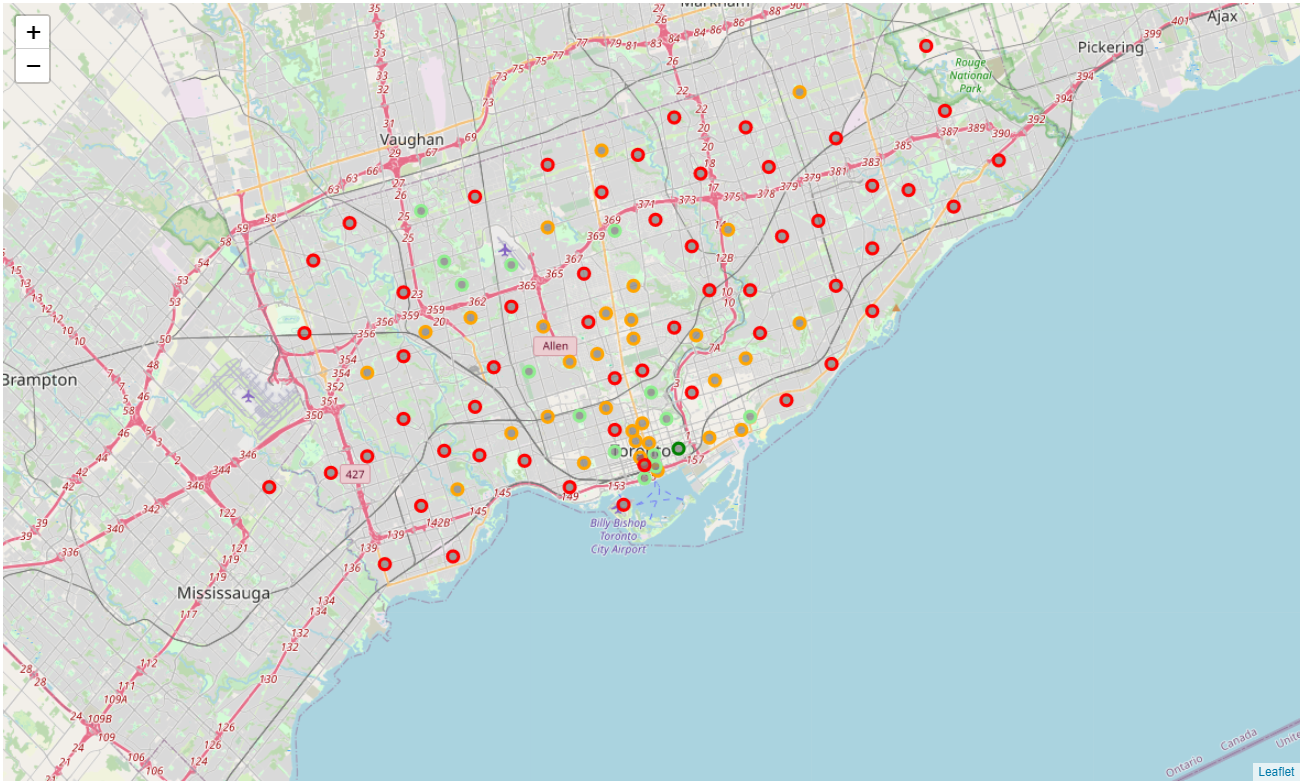

In [17]:
# Get dataframe of neighbourhoods without parks.
toronto_no_parks = toronto_parks[toronto_parks.Parks == 0]
toronto_no_parks.head()

Postal Code      Borough   Latitude  \
Agincourt                                 M1S  Scarborough  43.794200   
Alderwood, Long Branch                    M8W    Etobicoke  43.602414   
Bayview Village                           M2K   North York  43.786947   
Bedford Park, Lawrence Manor East         M5M   North York  43.733283   
Birch Cliff, Cliffside West               M1N  Scarborough  43.692657   

                                   Longitude  Parks  
Agincourt                         -79.262029      0  
Alderwood, Long Branch            -79.543484      0  
Bayview Village                   -79.385975      0  
Bedford Park, Lawrence Manor East -79.419750      0  
Birch Cliff, Cliffside West       -79.264848      0

We have seen before that there are 56 neighbourhoods without park. we cannot build a park in all that locations immediately, but we will start with 5 neighbourhoods.

In order to not have them all in the same side of the city, we will create 5 clusters.

In [18]:
# Set up matrix to use K-Means
X=toronto_no_parks[['Latitude', 'Longitude']]
print(type(X))

<class 'pandas.core.frame.DataFrame'>


In [29]:
# Create a k-Means instance for 5 clusters
k_means =  KMeans(init="k-means++", n_clusters=5, n_init=100)

In [30]:
# Execute the algorithm on the coordinates of the neighbourhoods without parks.
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [31]:
k_means.labels_

array([2, 0, 4, 4, 1, 3, 3, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 3, 2, 4, 0, 0,
       0, 1, 4, 3, 2, 0, 3, 0, 0, 4, 3, 1, 4, 2, 0, 0, 2, 0, 1, 3, 1, 3,
       0, 3, 3, 2, 1, 0, 0, 1, 4, 4, 2, 4], dtype=int32)

In [32]:
# We create a data frame with the toronto_no_parks-infomation plus the cluster.
# This will give us a warning, but we know what we are doing as the labels-array is the result of the coordinates of the toronto_no_parks-data frame.
df_no_parks_clustered = toronto_no_parks
df_no_parks_clustered['cluster'] = k_means.labels_

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [33]:
df_no_parks_clustered.head(6)

Postal Code       Borough  \
Agincourt                                            M1S   Scarborough   
Alderwood, Long Branch                               M8W     Etobicoke   
Bayview Village                                      M2K    North York   
Bedford Park, Lawrence Manor East                    M5M    North York   
Birch Cliff, Cliffside West                          M1N   Scarborough   
Brockton, Parkdale Village, Exhibition Place         M6K  West Toronto   

                                               Latitude  Longitude  Parks  \
Agincourt                                     43.794200 -79.262029      0   
Alderwood, Long Branch                        43.602414 -79.543484      0   
Bayview Village                               43.786947 -79.385975      0   
Bedford Park, Lawrence Manor East             43.733283 -79.419750      0   
Birch Cliff, Cliffside West                   43.692657 -79.264848      0   
Brockton, Parkdale Village, Exhibition Place  43.636847 -79.428191      0   

                                              cluster  
Agincourt                                           2  
Alderwood, Long Branch                              0  
Bayview Village                                     4  
Bedford Park, Lawrence Manor East                   4  
Birch Cliff, Cliffside West                         1  
Brockton, Parkdale Village, Exhibition Place        3

In [37]:
# Map of Neighbourhoods with parks
map_toronto_no_parks_clustered = folium.Map(location=[43.679563, -79.377529], zoom_start=11)

clusterColors = ['red', 'orange', 'yellow', 'purple', 'green']

# add markers to map
for lat, lng, neighborhood, cluster in zip(df_no_parks_clustered['Latitude'], df_no_parks_clustered['Longitude']
                                                    , df_no_parks_clustered.index, df_no_parks_clustered['cluster']):
    label = '{} ({} cluster)'.format(neighborhood, clusterColors[cluster])
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=clusterColors[cluster],
        fill=True,
        fill_color='grey',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_no_parks_clustered)  

    
# Add cluster-centers
for i in range(5) :
    label = 'Center of {} cluster'.format(clusterColors[i])
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        k_means.cluster_centers_[i],  #[lat, lng],
        radius=10,
        popup=label,
        color=clusterColors[i],
        fill=True,
        fill_color=clusterColors[i],
        fill_opacity=1,
        parse_html=False).add_to(map_toronto_no_parks_clustered)  
    
    
map_toronto_no_parks_clustered

We apprecieate the five clusters in green, yellow, red, purple and orange.
Again, as the rendering of Folium-maps does not work in github, I insert the image here:
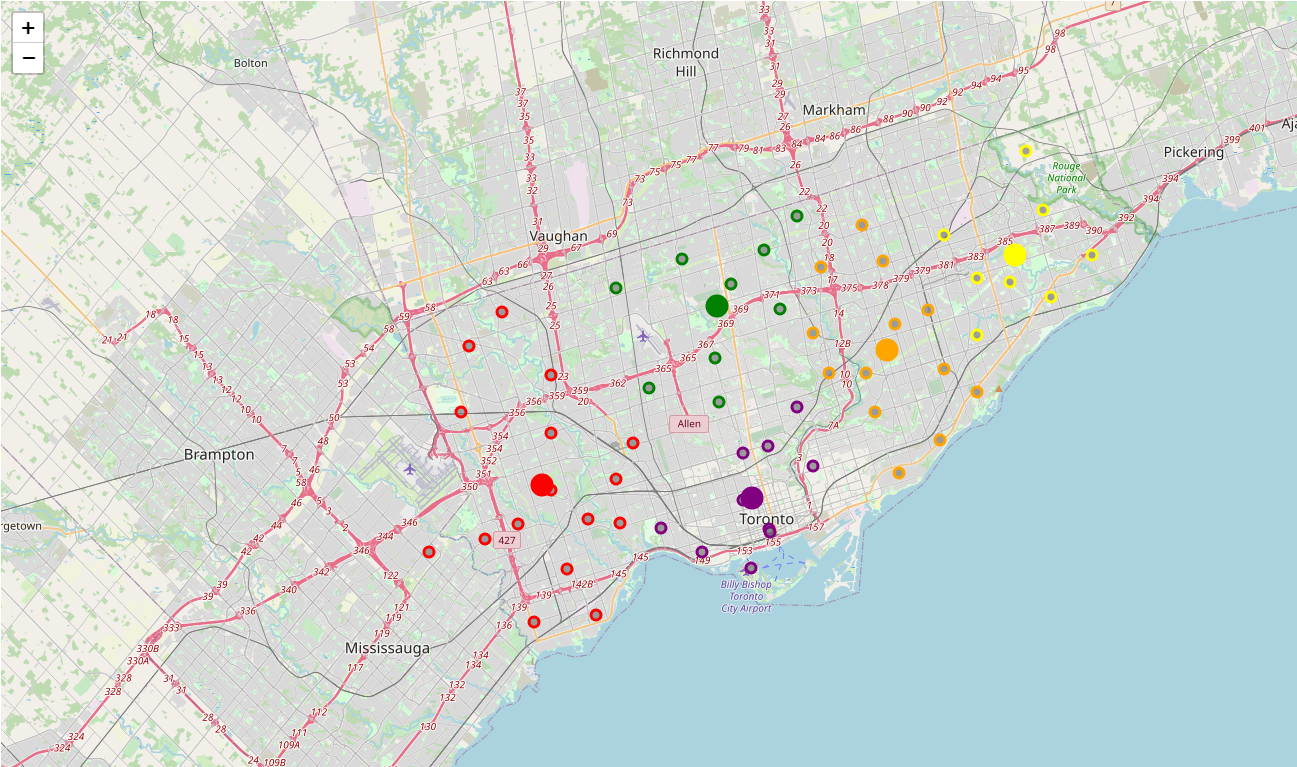

So, now we have five clusters from where to chose the neighbourhoods where new parks are to be created.
Our choices are:
<li> Brockton, Parkdale Village, Exhibition Place
<li> Alderwood, Long Branch
<li> Bedford Park, Lawrence Manor East
<li> Guildwood, Morningside, West Hill
<li> Wexford, Maryvale

In [38]:
# Show the map of Toronto with the clusters again, this time marking the chosen neighbourhoods with bigger circles.
map_toronto_no_parks_clustered = folium.Map(location=[43.679563, -79.377529], zoom_start=11)

clusterColors = ['red', 'orange', 'yellow', 'purple', 'green']
selectedNeighborHoods = ['Brockton, Parkdale Village, Exhibition Place','Alderwood, Long Branch','Bedford Park, Lawrence Manor East','Guildwood, Morningside, West Hill','Wexford, Maryvale']

# add markers to map
for lat, lng, neighborhood, cluster in zip(df_no_parks_clustered['Latitude'], df_no_parks_clustered['Longitude']
                                                    , df_no_parks_clustered.index, df_no_parks_clustered['cluster']):
    label = '{} ({} cluster)'.format(neighborhood, clusterColors[cluster])
    popupLabel = folium.Popup(label, parse_html=True)
    
    fixed_label = ""
    circle_radius = 5
    
    if neighborhood in selectedNeighborHoods :
        fixed_label = label
        circle_radius = 10
    
    folium.CircleMarker(
        [lat, lng],
        radius=circle_radius,
        popup=popupLabel,
        color=clusterColors[cluster],
        fill=True,
        fill_color='grey',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_no_parks_clustered)  

    
# Add cluster-centers
for i in range(5) :
    label = 'Center of {} cluster'.format(clusterColors[i])
    popupLabel = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        k_means.cluster_centers_[i],
        radius=10,
        popup=popupLabel,
        color=clusterColors[i],
        fill=True,
        fill_color=clusterColors[i],
        fill_opacity=1,
        parse_html=False).add_to(map_toronto_no_parks_clustered)  
    
    
map_toronto_no_parks_clustered

And again, we add a copy of the image here because in github, the Folium-maps do not render.
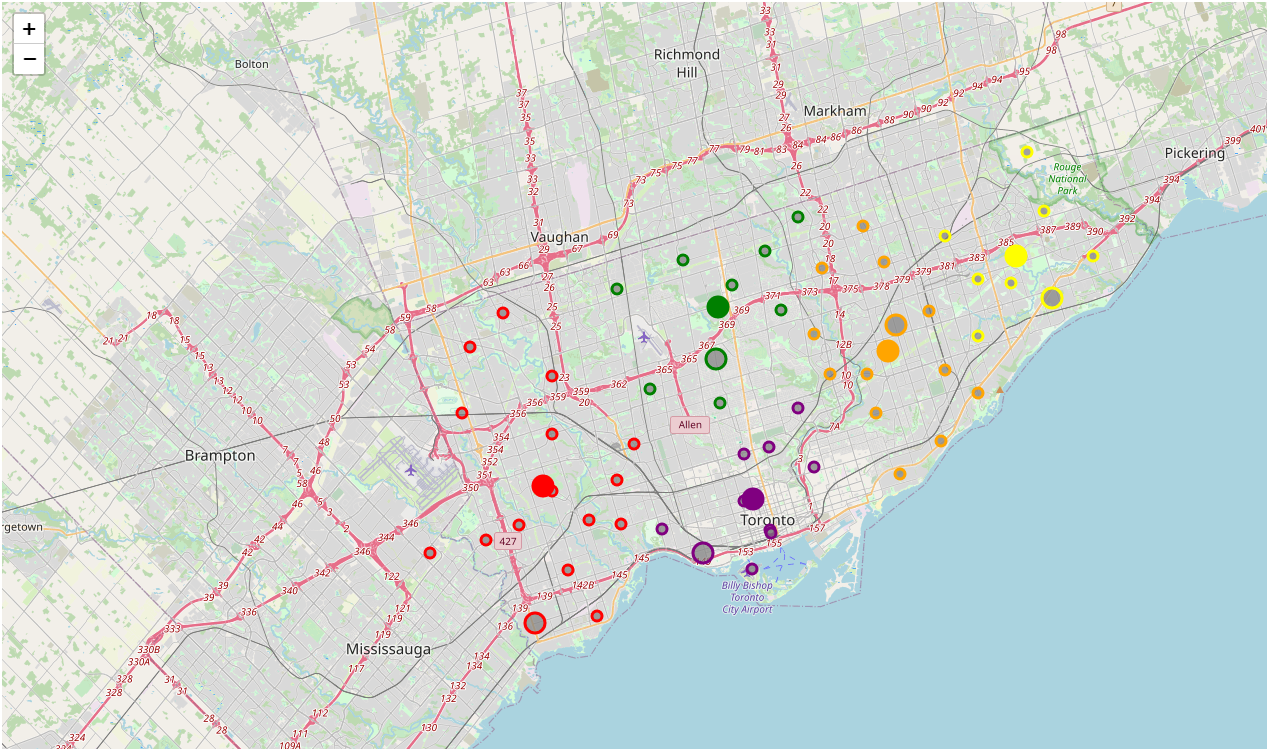